#### IMPORT문은 여기에만 추가하세요

In [39]:
# 기본 Import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 학습에 사용되는 자잘한 것들
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, f1_score, roc_auc_score, adjusted_rand_score, silhouette_score,precision_score, recall_score
)
from datetime import datetime

#### 전역변수 추가할거면 여기에 하세요 아래에는 모두 전역 변수로 사용할거임 코드 안꼬이게

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
encoding_dim = 64
EPOCHS = 10
LEARNING_RATE = 2e-3
num_classes = 2

#### 모델입니다.

In [41]:
class VariationalDecoder(nn.Module):
    def __init__(self, encoding_dim):
        super(VariationalDecoder, self).__init__()
        self.fc_mu = nn.Linear(encoding_dim, encoding_dim)
        self.fc_logvar = nn.Linear(encoding_dim, encoding_dim)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )

    def forward(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [42]:
class BaseModel(nn.Module):
    """
    모델 구조 수정 금지.
    """
    def __init__(self, encoding_dim, cat_features, num_features, num_classes, cat_cardinalities):
        super(BaseModel, self).__init__()
        # cat_cardinalities는 각 범주형 변수의 고유값 개수 리스트
        self.cat_embeddings = nn.ModuleList([nn.Embedding(cardinality, 5) for cardinality in cat_cardinalities])
        self.fc_cat = nn.Linear(len(cat_features) * 5 + len(num_features), 64)
        self.encoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = VariationalDecoder(encoding_dim)
        self.classifier = nn.Sequential(
            #Linear Input을 encoding_dim으로 잡았습니다. 이건 바꾸려면 바꾸셈ㅇㅇ
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x_cat, x_num):
        # 주석처리된 행들은 모두 디버깅용 행입니다.
        # Apply embedding layers
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        #print('len(embeddings : )',len(embeddings))
        #print('len(x_num) : ',len(x_num))
        x = torch.cat(embeddings + [x_num], dim=1)
        #print('len(x) : ',len(x))
        x = self.fc_cat(x)
        encoded = self.encoder(x)
        out = self.classifier(encoded)
        # print(out)
        return out


#### 인코딩입니다. ~~바꾸러면바꾸던가~~

In [43]:
def encode_and_standardize_data(data):
    label_encoders = {}
    data['Error Message'] = data['Error Message'].fillna('None')
    categorical_columns = ['Card Brand', 'Card Type', 'Card Number', 'Expires', 'Acct Open Date', 'Error Message']

    cat_cardinalities = []
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        cat_cardinalities.append(data[col].nunique())

    data['Zipcode'] = (data['Zipcode'] // 100).astype(int)
    le_zipcode = LabelEncoder()
    data['Zipcode'] = le_zipcode.fit_transform(data['Zipcode'])
    cat_cardinalities.append(data['Zipcode'].nunique())

    data['Merchandise Code'] = (data['Merchandise Code'] // 100).astype(int)
    le_merchandise_code = LabelEncoder()
    data['Merchandise Code'] = le_merchandise_code.fit_transform(data['Merchandise Code'])
    cat_cardinalities.append(data['Merchandise Code'].nunique())

    data['Has Chip'] = np.where(data['Has Chip'] == True, 1, 0)
    cat_cardinalities.append(data['Has Chip'].nunique())

    data['Birth Year'] = data['Birth Year'] - data['Birth Year'].min()
    data['Year PIN last Changed'] = data['Year PIN last Changed'] - data['Year PIN last Changed'].min()

    # Continuous columns for StandardScaler
    continuous_columns = [
        'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month', 'Per Capita Income - Zipcode',
        'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Year', 'Month', 'Day', 'Amount'
    ]
    scaler = StandardScaler()
    data[continuous_columns] = scaler.fit_transform(data[continuous_columns])

    # Identify categorical and numerical features
    categorical_columns += ['Zipcode', 'Merchandise Code', 'Has Chip']
    cat_features = data[categorical_columns].astype(int)  # Ensure categorical features are integer
    num_features = data[continuous_columns]

    return cat_features, num_features, cat_cardinalities


#### TRAIN, TEST 받아오기입니다.
여기에 Train / Val 나누기까지 추가했음.
추가적으로 y에 대해서는 'No' -> 0, 'Yes' -> 1로 변환.

In [44]:
# 원본 데이터 로드
full_data = pd.read_csv('../data/train.csv')

# train, val 나누기 + x랑 y 분리했읍니다
train_data = full_data[full_data['Month'].between(1,10)].copy() # 1~10월 Train
y_train = train_data['Is Fraud?'].map({'No':0,'Yes':1})
train_data = train_data.drop('Is Fraud?',axis=1)
val_data = full_data[full_data['Month'].isin([11,12])].copy() # 11,12월 Validation
y_val = val_data['Is Fraud?'].map({'No':0,'Yes':1})
print(y_val)
val_data = val_data.drop('Is Fraud?',axis=1)
# test 데이터 로드
test_data = pd.read_csv('../data/test.csv')

# 이 아래에서는 인코딩 및 스탠다드화 진행
x_cat_train, x_num_train, cat_cardinalities_train = encode_and_standardize_data(train_data)
x_cat_val, x_num_val, cat_cardinalities_val = encode_and_standardize_data(val_data)
x_cat_test, x_num_test, cat_cardinalities_test = encode_and_standardize_data(test_data)


191        0
192        0
193        0
194        0
195        0
          ..
1644763    0
1644764    0
1644765    0
1644766    0
1644767    0
Name: Is Fraud?, Length: 278788, dtype: int64


In [45]:
#확인용 코드 - 확인해볼거면 켜시고
#print(x_cat_test.iloc[1], x_num_test.iloc[1], cat_cardinalities_test,sep='\n')

In [46]:
# Torch tensor로 변환
x_cat_train_tensor = torch.tensor(x_cat_train.values, dtype=torch.long)  # 정수형
x_num_train_tensor = torch.tensor(x_num_train.values, dtype=torch.float32)  # 실수형

x_cat_val_tensor = torch.tensor(x_cat_val.values, dtype=torch.long)  # 정수형
x_num_val_tensor = torch.tensor(x_num_val.values, dtype=torch.float32)  # 실수형

x_cat_test_tensor = torch.tensor(x_cat_test.values, dtype=torch.long)
x_num_test_tensor = torch.tensor(x_num_test.values, dtype=torch.float32)

# Dataset 및 DataLoader 정의
train_dataset = TensorDataset(x_cat_train_tensor, x_num_train_tensor, torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(x_cat_val_tensor, x_num_val_tensor, torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(x_cat_test_tensor, x_num_test_tensor)  # 테스트 데이터는 레이블이 없으므로 제외

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False,num_workers=7, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,num_workers=7, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=7, pin_memory=True)

#### 디버깅을 하고 싶다면 나에게..(아래에서 디버깅을 진행하고 모델 학습을 돌리러 갑시다)
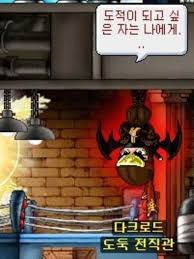

In [47]:
# 여기서 디버깅 진행하시면 됩니다. 아래는 샘플 모델


In [48]:
model = BaseModel(
    encoding_dim=encoding_dim, 
    cat_features=x_cat_train.columns, 
    num_features=x_num_train.columns, 
    num_classes=num_classes, 
    cat_cardinalities=cat_cardinalities_train
).to(DEVICE)
# 디버깅코드 - 모델 출력 테스트
#output = model(x_cat_train_tensor, x_num_train_tensor)
#print(output)

# Loss 함수 및 Optimizer 정의
criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()  # Reconstruction Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)




In [49]:

# 학습 루프
def train(model, train_loader, optimizer, criterion, device, scaler = torch.GradScaler('cuda')):
    model.train()
    total_loss = 0
    total_reconstruction_loss = 0
    total_kl_loss = 0
    correct = 0
    total = 0

    for x_cat, x_num, y in train_loader:
        x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.autocast("cuda"):  # Mixed Precision
            # Forward pass
            embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
            x = torch.cat(embeddings + [x_num], dim=1)
            x = model.fc_cat(x)
            encoded = model.encoder(x)
            
            # Variational Decoder
            reconstructed, mu, logvar = model.decoder(encoded)
            out = model.classifier(encoded)

            # Loss 계산
            classification_loss = criterion(out, y)
            reconstruction_loss = reconstruction_criterion(reconstructed, x)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            loss = classification_loss + reconstruction_loss + kl_loss

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Metrics 계산
        total_loss += loss.item()
        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()
        _, predicted = out.max(1)
        correct += predicted.eq(y).sum().item()
        total += y.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), total_reconstruction_loss / len(train_loader), total_kl_loss / len(train_loader), accuracy

# 평가 루프
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    correct = 0
    total = 0

    with torch.no_grad():
        for x_cat, x_num, y in val_loader:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)

            with autocast():  # Mixed Precision
                # Forward pass
                embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
                x = torch.cat(embeddings + [x_num], dim=1)
                x = model.fc_cat(x)
                encoded = model.encoder(x)
                out = model.classifier(encoded)

                # Loss 계산
                loss = criterion(out, y)
                total_loss += loss.item()

                # 예측값 저장 및 정확도 계산
                _, predicted = out.max(1)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                correct += predicted.eq(y).sum().item()
                total += y.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), y_true, y_pred, accuracy


In [50]:
# TensorBoard Writer 초기화
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_dir = f"runs/Variational_Anomaly{current_time}_lr={LEARNING_RATE}_epochs={EPOCHS}"
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_rec_loss, train_kl_loss, train_accuracy = train(model, train_loader, optimizer, criterion, DEVICE)
    
    # Validation
    val_loss, y_true, y_pred, val_accuracy = evaluate(model, val_loader, criterion, DEVICE)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, y_pred, multi_class="ovr") if num_classes > 2 else roc_auc_score(y_true, y_pred)

    # TensorBoard 기록
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Train_Reconstruction", train_rec_loss, epoch)
    writer.add_scalar("Loss/Train_KL", train_kl_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
    writer.add_scalar("Metrics/F1", f1, epoch)
    writer.add_scalar("Metrics/Precision", precision, epoch)
    writer.add_scalar("Metrics/Recall", recall, epoch)
    writer.add_scalar("Metrics/AUC", auc, epoch)



    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} (Reconstruction: {train_rec_loss:.4f}, KL: {train_kl_loss:.4f})")
    print(f"Validation Loss: {val_loss:.4f}, F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

writer.close()

C:\Users\user\AppData\Local\Temp\ipykernel_29416\367110765.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
